# Fine-tuning Stable Diffusion with DreamBooth

## Learning Objectives
- aaa

## Introduction

In this example, we implement DreamBooth, a fine-tuning technique to teach new visual concepts to text-conditioned Diffusion models with just 3 - 5 images. 

DreamBooth was proposed in [DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation](https://arxiv.org/abs/2208.12242) by Ruiz et al.

DreamBooth, in a sense, is similar to the
[traditional way of fine-tuning a text-conditioned Diffusion model except](https://keras.io/examples/generative/finetune_stable_diffusion/) for a few gotchas. This example assumes that you have basic familiarity with Diffusion models and how to fine-tune them. Here are some reference examples that might help you to get familiarized quickly:

* [High-performance image generation using Stable Diffusion in KerasCV](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/)
* [Teach StableDiffusion new concepts via Textual Inversion](https://keras.io/examples/generative/fine_tune_via_textual_inversion/)
* [Fine-tuning Stable Diffusion](https://keras.io/examples/generative/finetune_stable_diffusion/)

First, let's install the latest versions of KerasCV and TensorFlow.

In [1]:
# Remove comment out and install.
# !pip install --user keras-cv==0.5.1

If you're running the code, please ensure you're using a GPU with at least 24 GBs of
VRAM.

## Initial imports

In [2]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [3]:
import math

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

## Usage of DreamBooth

... is very versatile. By teaching Stable Diffusion about your favorite visual
concepts, you can

* Recontextualize objects in interesting ways:

  ![](https://i.imgur.com/4Da9ozw.png)

* Generate artistic renderings of the underlying visual concept:

  ![](https://i.imgur.com/nI2N8bI.png)


And many other applications. We welcome you to check out the original
[DreamBooth paper](https://arxiv.org/abs/2208.12242) in this regard.

## Download the instance and class images

DreamBooth uses a technique called "prior preservation" to meaningfully guide the training procedure such that the fine-tuned models can still preserve some of the prior semantics of the visual concept you're introducing. To know more about the idea of "prior preservation" refer to [this document](https://dreambooth.github.io/).

Here, we need to introduce a few key terms specific to DreamBooth:

* **Unique class**: Examples include "dog", "person", etc. In this example, we use "dog".
* **Unique identifier**: A unique identifier that is prepended to the unique class while forming the "instance prompts". In this example, we use "sks" as this unique identifier.
* **Instance prompt**: Denotes a prompt that best describes the "instance images". An example prompt could be - "f"a photo of {unique_id} {unique_class}". So, for our example, this becomes - "a photo  of sks dog".
* **Class prompt**: Denotes a prompt without the unique identifier. This prompt is used for generating "class images" for prior preservation. For our example, this prompt is - "a photo of dog".
* **Instance images**: Denote the images that represent the visual concept you're trying to teach aka the "instance prompt". This number is typically just 3 - 5. We typically gather these images ourselves.
* **Class images**: Denote the images generated using the "class prompt" for using prior preservation in DreamBooth training. We leverage the pre-trained model before fine-tuning it to generate these class images. Typically, 200 - 300 class images are enough.

To keep the runtime of this example short, the authors of this example have gone ahead and generated some class images using [this notebook](https://colab.research.google.com/gist/sayakpaul/6b5de345d29cf5860f84b6d04d958692/generate_class_priors.ipynb).

**Note** that prior preservation is an optional technique used in DreamBooth, but it almost always helps in improving the quality of the generated images.

In [4]:
instance_images_root = tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/instance-images.tar.gz",
    untar=True,
)
class_images_root = tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/class-images.tar.gz",
    untar=True,
)

## Visualize images

First, let's load the image paths.

In [5]:
instance_image_paths = [
    os.path.join(instance_images_root, d)
    for d in os.listdir(instance_images_root)
]
class_image_paths = [
    os.path.join(class_images_root, d) for d in os.listdir(class_images_root)
]

Then we load the images from the paths.

In [6]:
def load_images(image_paths):
    images = [np.array(keras.utils.load_img(path)) for path in image_paths]
    return images

And then we make use a utility function to plot the loaded images.

In [7]:
def plot_images(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")

**Instance images**:

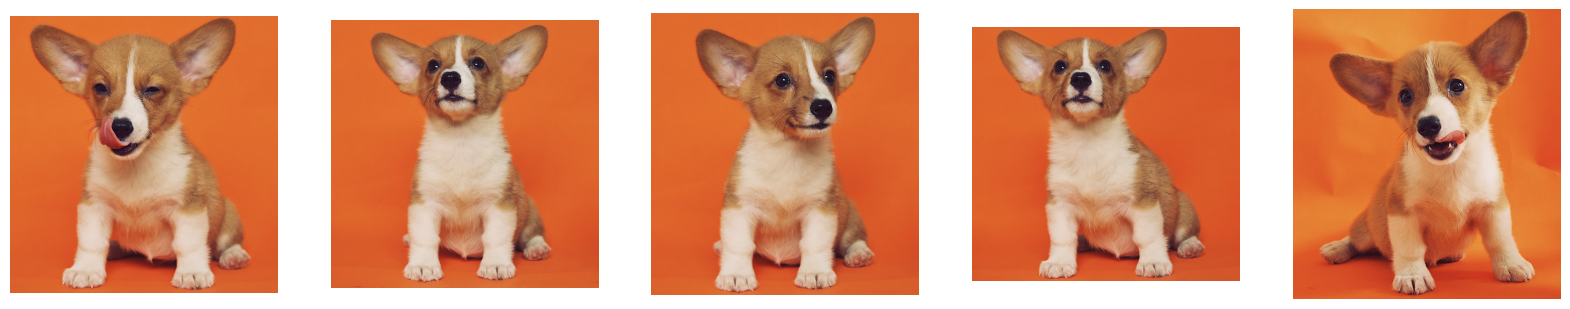

In [8]:
plot_images(load_images(instance_image_paths[:5]))

**Class images**:

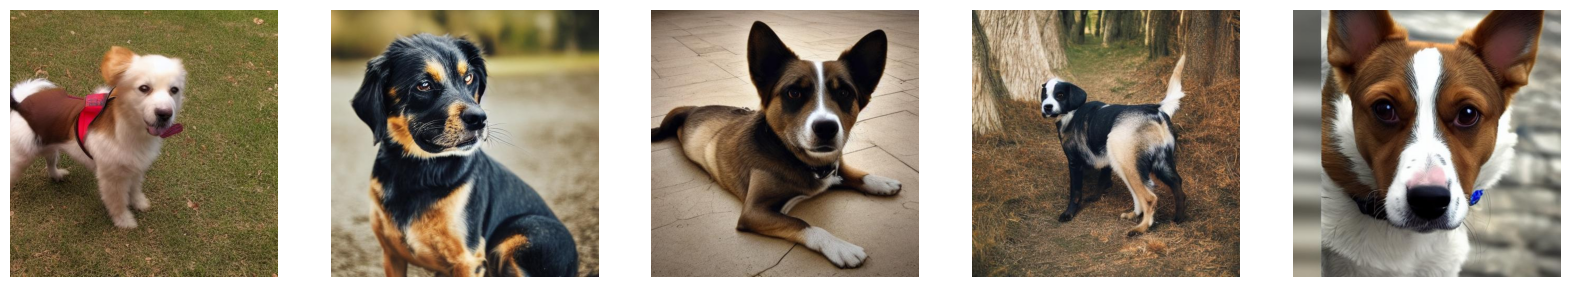

In [9]:
plot_images(load_images(class_image_paths[:5]))

## Prepare datasets

Dataset preparation includes two stages: (1): preparing the captions, (2) processing the
images.

### Prepare the captions

In [10]:
# Since we're using prior preservation, we need to match the number
# of instance images we're using. We just repeat the instance image paths
# to do so.
new_instance_image_paths = []
for index in range(len(class_image_paths)):
    instance_image = instance_image_paths[index % len(instance_image_paths)]
    new_instance_image_paths.append(instance_image)

# We just repeat the prompts / captions per images.
unique_id = "sks"
class_label = "dog"

instance_prompt = f"a photo of {unique_id} {class_label}"
instance_prompts = [instance_prompt] * len(new_instance_image_paths)

class_prompt = f"a photo of {class_label}"
class_prompts = [class_prompt] * len(class_image_paths)

Next, we embed the prompts to save some compute.

In [11]:
import itertools

# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
padding_token = 49407
max_prompt_length = 77

# Load the tokenizer.
tokenizer = keras_cv.models.stable_diffusion.SimpleTokenizer()


# Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [padding_token] * (max_prompt_length - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty(
    (len(instance_prompts) + len(class_prompts), max_prompt_length)
)

for i, caption in enumerate(itertools.chain(instance_prompts, class_prompts)):
    tokenized_texts[i] = process_text(caption)

## Prepare the images

In [12]:
resolution = 512
auto = tf.data.AUTOTUNE

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(resolution, resolution),
        keras_cv.layers.RandomFlip(),
        keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (resolution, resolution))
    return image, tokenized_text


def apply_augmentation(image_batch, tokenized_texts):
    return augmenter(image_batch), tokenized_texts


def prepare_dict(instance_only=True):
    def fn(image_batch, tokenized_texts):
        if instance_only:
            batch_dict = {
                "instance_images": image_batch,
                "instance_texts": tokenized_texts,
            }
            return batch_dict
        else:
            batch_dict = {
                "class_images": image_batch,
                "class_texts": tokenized_texts,
            }
            return batch_dict

    return fn


def assemble_dataset(
    image_paths, tokenized_texts, instance_only=True, batch_size=1
):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.map(process_image, num_parallel_calls=auto)
    dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=auto)

    prepare_dict_fn = prepare_dict(instance_only=instance_only)
    dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)
    return dataset

## Assemble dataset

In [13]:
BATCH_SIZE = 2

instance_dataset = assemble_dataset(
    new_instance_image_paths,
    tokenized_texts[: len(new_instance_image_paths)],
    batch_size=BATCH_SIZE,
)
class_dataset = assemble_dataset(
    class_image_paths,
    tokenized_texts[len(new_instance_image_paths) :],
    instance_only=False,
    batch_size=BATCH_SIZE,
)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

## Check shapes

Now that the dataset has been prepared, let's quickly check what's inside it.

In [14]:
sample_batch = next(iter(train_dataset))
print(sample_batch[0].keys(), sample_batch[1].keys())

for k in sample_batch[0]:
    print(k, sample_batch[0][k].shape)

for k in sample_batch[1]:
    print(k, sample_batch[1][k].shape)

dict_keys(['instance_images', 'instance_texts']) dict_keys(['class_images', 'class_texts'])
instance_images (2, 512, 512, 3)
instance_texts (2, 77)
class_images (2, 512, 512, 3)
class_texts (2, 77)


During training, we make use of these keys to gather the images and text embeddings and
concat them accordingly.

## DreamBooth training loop

Our DreamBooth training loop is very much inspired by
[this script](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py)
provided by the Diffusers team at Hugging Face. However, there is an important
difference to note. We only fine-tune the UNet (the model responsible for predicting
noise) and don't fine-tune the text encoder in this example. If you're looking for an
implementation that also performs the additional fine-tuning of the text encoder, refer
to [this repository](https://github.com/sayakpaul/dreambooth-keras/).

In [15]:
import tensorflow.experimental.numpy as tnp


class DreamBoothTrainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py

    def __init__(
        self,
        diffusion_model,
        vae,
        text_encoder,
        noise_scheduler,
        max_prompt_length,
        use_mixed_precision=False,
        prior_loss_weight=1.0,
        max_grad_norm=1.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.text_encoder = text_encoder
        self.noise_scheduler = noise_scheduler
        self.max_prompt_length = max_prompt_length
        self.prior_loss_weight = prior_loss_weight
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        instance_batch = inputs[0]
        class_batch = inputs[1]

        instance_images = instance_batch["instance_images"]
        instance_text = instance_batch["instance_texts"]
        class_images = class_batch["class_images"]
        class_text = class_batch["class_texts"]

        images = tf.concat([instance_images, class_images], 0)
        tokenized_texts = tf.concat([instance_text, class_text], 0)
        batch_size = tf.shape(images)[0]
        POS_IDS = tf.convert_to_tensor(
            [list(range(max_prompt_length))], dtype=tf.int32
        )

        with tf.GradientTape(persistent=True) as tape:
            embedded_texts = text_encoder(
                [tokenized_texts, POS_IDS], training=True
            )

            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(
                self.vae(images, training=False)
            )
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t),
                timesteps,
                fn_output_signature=tf.float32,
            )
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, embedded_texts],
                training=True,
            )
            loss = self.compute_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the text encoder and diffusion model.
        text_trainable_vars = self.text_encoder.trainable_variables
        diffusion_trainable_vars = self.diffusion_model.trainable_variables
        trainable_vars = text_trainable_vars + diffusion_trainable_vars
        gradients = tape.gradient(loss, trainable_vars)

        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def compute_loss(self, target, model_pred):
        # Chunk the noise and model_pred into two parts and compute the loss
        # on each part separately.
        # Since the first half of the inputs has instance samples and the second half
        # has class samples, we do the chunking accordingly.
        model_pred, model_pred_prior = tf.split(
            model_pred, num_or_size_splits=2, axis=0
        )
        target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

        # Compute instance loss.
        loss = self.compiled_loss(target, model_pred)

        # Compute prior loss.
        prior_loss = self.compiled_loss(target_prior, model_pred_prior)

        # Add the prior loss to the instance loss.
        loss = loss + self.prior_loss_weight * prior_loss
        return loss

    def save_weights(
        self, filepath, overwrite=True, save_format=None, options=None
    ):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=f"{filepath}/diffusion.h5",
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

        self.text_encoder.save_weights(
            filepath=f"{filepath}/text_encoder.h5",
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

## Trainer initialization

In [16]:
# Comment it if you are not using a GPU having tensor cores.
tf.keras.mixed_precision.set_global_policy("mixed_float16")

use_mp = True  # Set it to False if you're not using a GPU with tensor cores.

image_encoder = keras_cv.models.stable_diffusion.ImageEncoder(resolution)
text_encoder = keras_cv.models.stable_diffusion.TextEncoderV2(max_prompt_length)

dreambooth_trainer = DreamBoothTrainer(
    diffusion_model=keras_cv.models.stable_diffusion.DiffusionModelV2(
        resolution, resolution, max_prompt_length
    ),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    text_encoder=text_encoder,
    noise_scheduler=keras_cv.models.stable_diffusion.NoiseScheduler(),
    max_prompt_length=max_prompt_length,
    use_mixed_precision=use_mp,
)

# Hyperparameters
learning_rate = 1e-6
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
dreambooth_trainer.compile(optimizer=optimizer, loss="mse")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB, compute capability 8.0


## Train!

We first calculate the number of epochs, we need to train for.

In [17]:
num_update_steps_per_epoch = train_dataset.cardinality() // BATCH_SIZE
max_train_steps = 600
epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
print(f"Training for {epochs} epochs.")

Training for 12 epochs.


And then we start training!

In [18]:
ckpt_path = "checkopoints"
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
dreambooth_trainer.fit(train_dataset, epochs=epochs, callbacks=[ckpt_callback])

Epoch 1/12
100/100 [==============================] - 510s 1s/step - loss: 0.1196
Epoch 2/12
100/100 [==============================] - 114s 1s/step - loss: 0.1014
Epoch 3/12
100/100 [==============================] - 114s 1s/step - loss: 0.1032
Epoch 4/12
100/100 [==============================] - 114s 1s/step - loss: 0.1154
Epoch 5/12
100/100 [==============================] - 114s 1s/step - loss: 0.1055
Epoch 6/12
100/100 [==============================] - 114s 1s/step - loss: 0.1163
Epoch 7/12
100/100 [==============================] - 114s 1s/step - loss: 0.0999
Epoch 8/12
100/100 [==============================] - 113s 1s/step - loss: 0.1029
Epoch 9/12
100/100 [==============================] - 114s 1s/step - loss: 0.1099
Epoch 10/12
100/100 [==============================] - 114s 1s/step - loss: 0.1043
Epoch 11/12
100/100 [==============================] - 114s 1s/step - loss: 0.1024
Epoch 12/12
100/100 [==============================] - 113s 1s/step - loss: 0.0972


## Cloud Training

In [19]:
# PROJECT = !gcloud config get-value project  # noqa: E999
# PROJECT = PROJECT[0]
# %env PROJECT=$PROJECT

In [20]:
# %%bash
# IMAGE_NAME=dreambooth_trainer
# TRAINING_APP_FOLDER=dreambooth
# IMAGE_URI=gcr.io/$PROJECT/$IMAGE_NAME

# gcloud builds submit --tag $IMAGE_URI $TRAINING_APP_FOLDER

In [21]:
# from google.cloud import aiplatform
# import time

# TRAIN_CONTAINER_URI = f"gcr.io/{PROJECT}/dreambooth_trainer"

# TRAIN_MACHINE_TYPE = "a2-highgpu-1g"
# TRAIN_ACCELERATOR_TYPE = "NVIDIA_TESLA_A100"
# TRAIN_NUM_GPU = 1

# # TRAIN_MACHINE_TYPE = "n1-standard-32"
# # TRAIN_ACCELERATOR_TYPE = "NVIDIA_TESLA_T4"
# # TRAIN_NUM_GPU = 2


# RESOLUTION = 512

# worker_pool_specs = [
#     {
#         "machine_spec": {
#             "machine_type": TRAIN_MACHINE_TYPE,
#             "accelerator_type": TRAIN_ACCELERATOR_TYPE,
#             "accelerator_count": TRAIN_NUM_GPU,
#         },
#         "replica_count": 1,
#         "disk_spec": {
#             "boot_disk_type": "pd-ssd",
#             "boot_disk_size_gb": 500,
#         },
#         "container_spec": {
#             "image_uri": TRAIN_CONTAINER_URI,
#             "command": [],
#         },
#     }
# ]

# TIMESTAMP = time.strftime("%Y%m%d_%H%M%S")
# JOB_NAME = f"dreambooth_training_{TRAIN_MACHINE_TYPE}_{TRAIN_ACCELERATOR_TYPE}_{TRAIN_NUM_GPU}"
# REGION = "us-central1"

# train_job = aiplatform.CustomJob(
#     display_name=JOB_NAME,
#     project=PROJECT,
#     location=REGION,
#     worker_pool_specs=worker_pool_specs,
#     staging_bucket=f"gs://{PROJECT}",
# )

# train_job.run()

# # model_path = os.path.join(model_dir, "saved_model.h5")
# # print("The trained model is saved as: ", model_path)

In [22]:
# tries = 10
# for i in range(tries):
#     try:
#         TIMESTAMP = time.strftime("%Y%m%d_%H%M%S")
#         JOB_NAME = f"dreambooth_training_{TRAIN_MACHINE_TYPE}_{TRAIN_ACCELERATOR_TYPE}_{TRAIN_NUM_GPU}"
#         REGION = "us-central1"

#         train_job = aiplatform.CustomJob(
#             display_name=JOB_NAME,
#             project=PROJECT,
#             location=REGION,
#             worker_pool_specs=worker_pool_specs,
#             staging_bucket=f"gs://{PROJECT}",
#         )

#         train_job.run()

#     except RuntimeError as e:
#         if i < tries - 1: # i is zero indexed
#             continue
#         else:
#             raise
#     break

## Experiments and inference

First, let's see how we can use the fine-tuned checkpoint for running inference.

In [23]:
# Initialize a new Stable Diffusion model.
dreambooth_model = keras_cv.models.StableDiffusionV2(
    img_width=resolution, img_height=resolution, jit_compile=True
)
dreambooth_model.diffusion_model.load_weights(f"{ckpt_path}/diffusion.h5")
dreambooth_model.text_encoder.load_weights(f"{ckpt_path}/text_encoder.h5")

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL++-M license at https://github.com/Stability-AI/stablediffusion/blob/main/LICENSE-MODEL


50/50 [==============================] - 45s 129ms/step


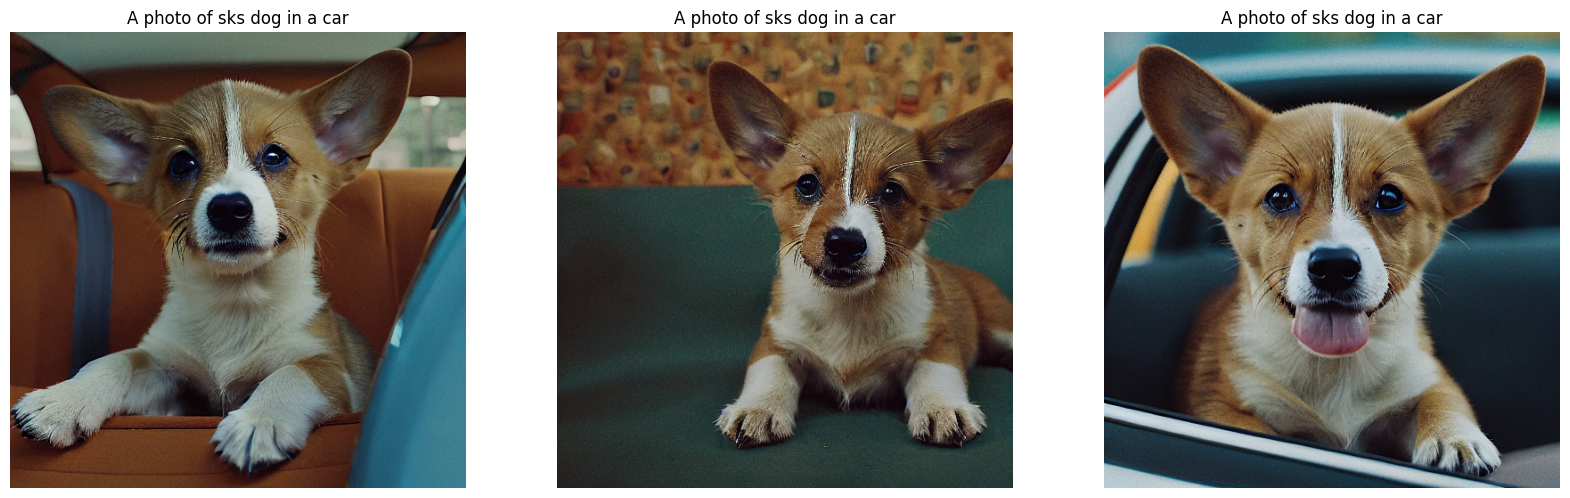

In [24]:
# Note how the unique identifier and the class have been used in the prompt.
prompt = f"A photo of {unique_id} {class_label} in a car"
num_imgs_to_gen = 3

images_dreamboothed = dreambooth_model.text_to_image(
    prompt, batch_size=num_imgs_to_gen
)
plot_images(images_dreamboothed, prompt)

50/50 [==============================] - 6s 128ms/step


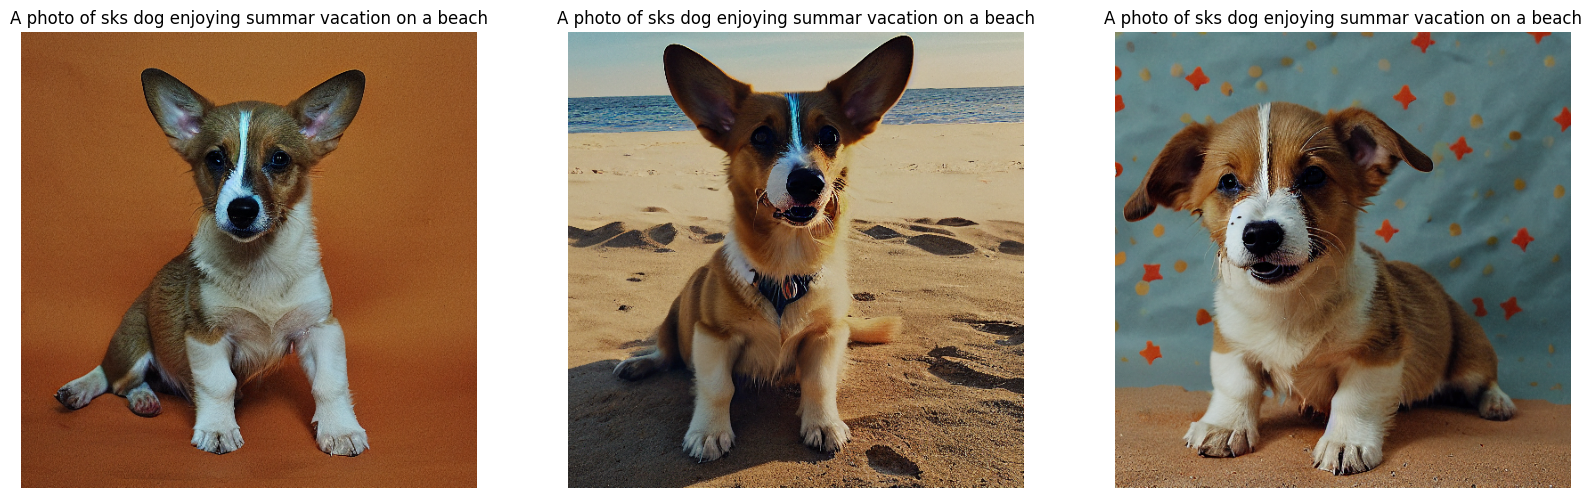

In [25]:
# Note how the unique identifier and the class have been used in the prompt.
prompt = (
    f"A photo of {unique_id} {class_label} enjoying summar vacation on a beach"
)
num_imgs_to_gen = 3

images_dreamboothed = dreambooth_model.text_to_image(
    prompt, batch_size=num_imgs_to_gen
)
plot_images(images_dreamboothed, prompt)

50/50 [==============================] - 6s 129ms/step


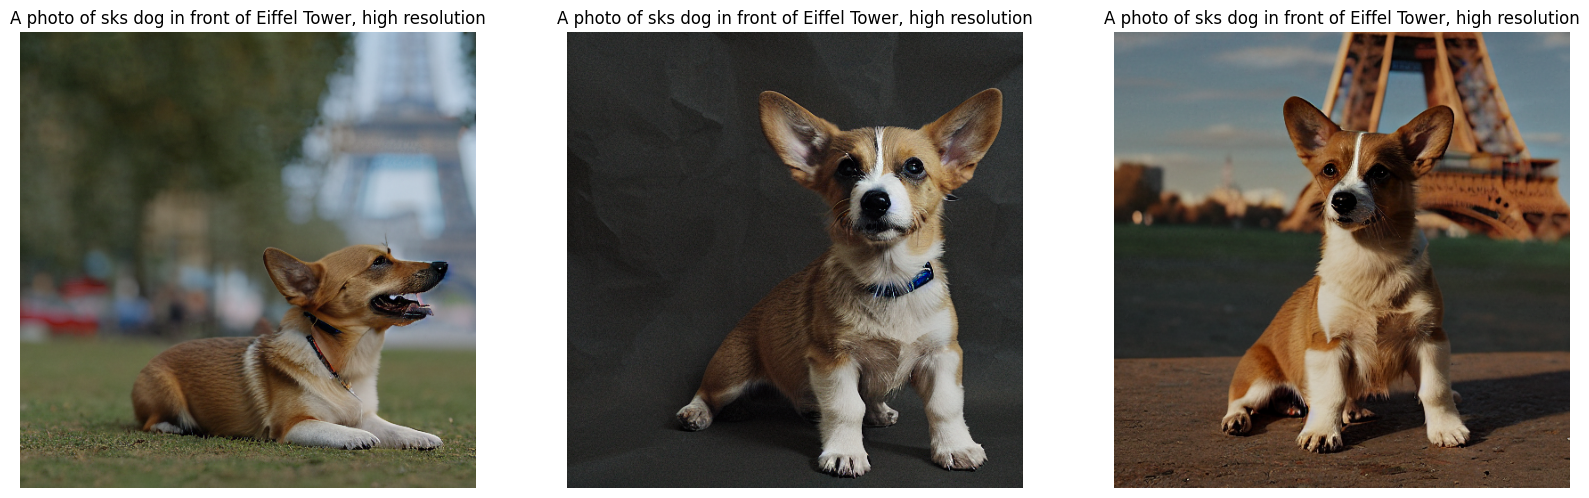

In [26]:
prompt = f"A photo of {unique_id} {class_label} in front of Eiffel Tower, high resolution"

images_dreamboothed = dreambooth_model.text_to_image(
    prompt, batch_size=num_imgs_to_gen
)
plot_images(images_dreamboothed, prompt)

Feel free to experiment with different prompts (don't forget to add the unique identifer
and the class label!) to see how the results change. We welcome you to check out our
codebase and more experimental results
[here](https://github.com/sayakpaul/dreambooth-keras#results). You can also read
[this blog post](https://huggingface.co/blog/dreambooth) to get more ideas.

## Acknowledgements
